# Module Imports

In [1]:
import os

import pandas as pd

# Loading the data

##### Using OS module to determine filepaths in OS independent manner as backslashes used on Windows and forward slashes used on Unix

In [2]:
working_directory = os.path.abspath('.')

In [3]:
training_data_location = os.path.join(working_directory, 'Data', 'train.csv')
testing_data_location = os.path.join(working_directory, 'Data', 'test.csv')

In [4]:
titanic_training_data = pd.read_csv(training_data_location)
titanic_testing_data = pd.read_csv(training_data_location)

# Initial data exploration

In [5]:
titanic_training_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Training data consist of the following columns:

    1) Passenger ID: Assuming this is unique
    2) Survived: This is a true(1)/false(0) of whether or not the passenger has survived
    3) Pclass: class of ticket, this is either lower (3), middle (2) or upper (1)
    4) Name: Passenger name as a string. It may be worth splitting passenger name into surnames to see if we can group by families
    5) Sex: categorical of either male or female
    6) SibSp: This is the number of siblings and spouses on-board the titanic
    7) Parch: This is the number of parents and children on-board the titanic
    8) Ticket number: I assume this is unique --> I wonder if there is any processing that can be done to extract more information.
    9) Fare: price paid for ticket
    10) Cabin: Cabin number, maybe this is something to do with location upon the titanic..may require some processing. Or maybe we can make a new column which represents whether or not a person has a Cabin.
    11) Embarked: Location at which person embarked the titanic. S is Southampton, Q is queenstown and C is Cherbourg


## Column Exploration
Before moving on, it is probably a good idea to ask some simple questions based on the columns available to us. The simplest question is probably what is the survival % or fraction amongst the different values for each column.

### Impact of sex

In [6]:
df_sex = titanic_training_data.groupby(['Sex', 'Survived']).size()
df_sex = df_sex.unstack('Survived') # Unstacking dataframe to get survived as column so can work out percentage
df_sex['surival_fraction'] = df_sex[1]/(df_sex[0] + df_sex[1]) # Make a new column which represents survival rate
df_sex

Survived,0,1,surival_fraction
Sex,,,
female,81,233,0.742038
male,468,109,0.188908


This tells us the following:

    1) This tells us that of all the females, 74% survived whereas only 18% of the men survived
    
At this stage is looks like sex should be included in models to predict whether or not someone survived.

## Impact of age

In [7]:
titanic_training_data.hist(column='Age', by=['Survived'], bins=10)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000024107CD8C50>,
      dtype=object)

It looks like if you are slightly younger or about 40 years old you are more likely to survive. The histogram isn't providing any numbers so would be useful to generate a statistics table.

In [8]:
temp_df = titanic_testing_data #Making temp dataframe as I don't want to change the source
temp_df.Age = temp_df.Age // 10 * 10 #Splitting age into 10 year brackets
temp_df.groupby(['Age']).mean()

,PassengerId,Survived,Pclass,SibSp,Parch,Fare
Age,,,,,,
0.0,424.741935,0.612903,2.629032,1.854839,1.403226,30.576679
10.0,444.362745,0.401961,2.470588,0.666667,0.470588,32.535132
20.0,433.231818,0.350000,2.450000,0.322727,0.250000,27.278937
30.0,472.449102,0.437126,2.113772,0.353293,0.329341,40.377294
40.0,465.606742,0.382022,1.966292,0.370787,0.471910,38.002297
50.0,440.187500,0.416667,1.562500,0.291667,0.270833,47.933333
60.0,433.736842,0.315789,1.473684,0.263158,0.368421,48.367542
70.0,496.500000,0.000000,1.833333,0.166667,0.166667,30.197233
80.0,631.000000,1.000000,1.000000,0.000000,0.000000,30.000000


The above table is hard to visualise so a plot would be more useful. N.B. The mean for the survived column corresponds to the fraction that survived as the original data is binary and a mean of 1s and 0s corresponds to the fraction of 1s which is the fractional surival.

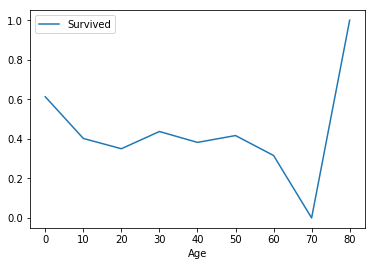

In [9]:
temp_df.groupby(['Age']).mean().plot(y='Survived')

Now it is easier to see that younger people tend to survive more than older people. Surival rate seems to drop from 50 years onwards to about 70 years. Then spikes at 80, however, maybe this is an anomaly? At this stage it looks like age has an impact, but not nearly as big as sex.

## Impact of ticket class

In [10]:
titanic_training_data.groupby(['Pclass']).mean()

,PassengerId,Survived,Age,SibSp,Parch,Fare
Pclass,,,,,,
1,461.597222,0.629630,38.233441,0.416667,0.356481,84.154687
2,445.956522,0.472826,29.877630,0.402174,0.380435,20.662183
3,439.154786,0.242363,25.140620,0.615071,0.393075,13.675550


Passengers who have higher classes of tickets (lower number) have a much higher survival rate. Interestingly the age seems to be correlated to ticket class also. Lower ticket class holders also seem to have a higher number of siblings and spouses onboard the titanic.

## Impact of family members

### Siblings and spouses

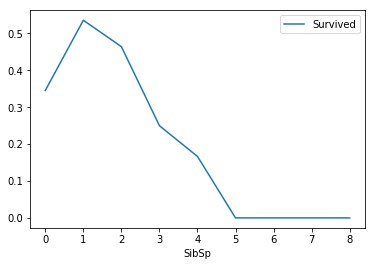

In [11]:
titanic_training_data.groupby(['SibSp']).mean().plot(y='Survived')

Seems having siblings and spouses onboard is useful up to 2, however, anymore then that and there is a dramatic decrease in odds of surviving.

### Parents and children

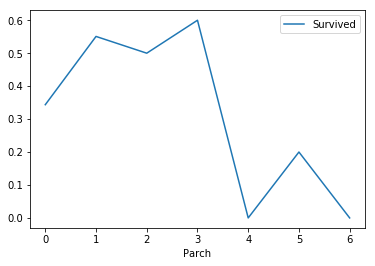

In [12]:
titanic_training_data.groupby(['Parch']).mean().plot(y='Survived')

Similar conclusions for number of parents and children onboard. After 3 parents/children the likelihood of surviving drops considerably.

## Impact of fare cost

In [13]:
titanic_training_data.groupby(['Survived']).mean()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
Survived,,,,,,
0,447.016393,2.531876,30.626179,0.553734,0.329690,22.117887
1,444.368421,1.950292,28.343690,0.473684,0.464912,48.395408


It looks like people who survive paid a higher fare cost. Interestingly they are also younger this is in agreement with the age trend that was observed before.

## Impact of Cabin

The cabin column is interesting because there are lots of empty values. Maybe an assumption to make would to state that if the value of the column is empty then that passenger did not have a private cabin. Then we can do a simple analysis based on survival rate of people with and without cabins.

In [14]:
temp_df = titanic_training_data
temp_df['Has_Cabin'] = ~titanic_training_data.Cabin.isnull()
temp_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Has_Cabin
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,False
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,True
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,False
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,True
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,False


Added a ~ to front of isnull() line to make equivalent to is not null.

In [15]:
temp_df.groupby(['Has_Cabin']).mean()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
Has_Cabin,,,,,,,
False,443.208151,0.299854,2.639010,27.555293,0.547307,0.365357,19.157325
True,455.401961,0.666667,1.196078,35.829297,0.441176,0.436275,76.141504


If a passenger had a cabin then they had a 66% chance of surviving the titanic. If the passenger did not have a cabin then they has only a 29% chance of surviving the titanic. This is therefore quite a significant factor. This suggest that something about the having access to a cabin helped someone survive e.g. potentially better initial locations.

The next question is whether or not there is a difference in survival rate depending on the type of Cabin. It looks like the cabin numbers are prefixed with a letter, this is presumably something to do with location so we can make another column which corresponds to cabin location using some string processing.

In [16]:
temp_df['Processed_Cabin'] = temp_df.Cabin.str.get(0).fillna('NoCabin')
temp_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Has_Cabin,Processed_Cabin
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,False,NoCabin
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,True,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,False,NoCabin
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,True,C
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,False,NoCabin


Above I have obtained the first character of each row and replaced all the NaN with NoCabin

In [17]:
temp_df.groupby(['Processed_Cabin']).mean()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Has_Cabin
Processed_Cabin,,,,,,,,
A,439.600000,0.466667,1.000000,44.833333,0.133333,0.133333,39.623887,True
B,521.808511,0.744681,1.000000,34.955556,0.361702,0.574468,113.505764,True
C,406.440678,0.593220,1.000000,36.086667,0.644068,0.474576,100.151341,True
D,475.939394,0.757576,1.121212,39.032258,0.424242,0.303030,57.244576,True
E,502.437500,0.750000,1.312500,38.116667,0.312500,0.312500,46.026694,True
F,370.384615,0.615385,2.384615,19.954545,0.538462,0.538462,18.696792,True
G,216.000000,0.500000,3.000000,14.750000,0.500000,1.250000,13.581250,True
NoCabin,443.208151,0.299854,2.639010,27.555293,0.547307,0.365357,19.157325,False
T,340.000000,0.000000,1.000000,45.000000,0.000000,0.000000,35.500000,True


More than 50% of passengers in cabins in areas B, C, D, E and F surived. T looks suspicious, it may be an outlier therefore, worth looking at number of rows of T.

In [18]:
temp_df.groupby(['Processed_Cabin']).count()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Has_Cabin
Processed_Cabin,,,,,,,,,,,,,
A,15,15,15,15,15,12,15,15,15,15,15,15,15
B,47,47,47,47,47,45,47,47,47,47,47,45,47
C,59,59,59,59,59,51,59,59,59,59,59,59,59
D,33,33,33,33,33,31,33,33,33,33,33,33,33
E,32,32,32,32,32,30,32,32,32,32,32,32,32
F,13,13,13,13,13,11,13,13,13,13,13,13,13
G,4,4,4,4,4,4,4,4,4,4,4,4,4
NoCabin,687,687,687,687,687,529,687,687,687,687,0,687,687
T,1,1,1,1,1,1,1,1,1,1,1,1,1


Only one T so maybe this is noise?

## Impact of embarking location

In [19]:
temp_df.groupby(['Embarked']).mean()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Has_Cabin
Embarked,,,,,,,,
C,445.357143,0.553571,1.886905,30.814769,0.386905,0.363095,59.954144,0.410714
Q,417.896104,0.389610,2.909091,28.089286,0.428571,0.168831,13.276030,0.051948
S,449.527950,0.336957,2.350932,29.445397,0.571429,0.413043,27.079812,0.200311


More passengers from C survived. Presumably these are passengers with better tickets etc.

## Family Name

In [26]:
temp_df['Family_Name'] = temp_df.Name.str.split(',').str.get(0)
temp_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Has_Cabin,Processed_Cabin,Family_Name
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,False,NoCabin,Braund
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,True,C,Cumings
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,False,NoCabin,Heikkinen
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,True,C,Futrelle
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,False,NoCabin,Allen


In [35]:
temp_df.groupby(['Family_Name']).count().sort_values('Has_Cabin', ascending = False).head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Has_Cabin,Processed_Cabin
Family_Name,,,,,,,,,,,,,,
Andersson,9,9,9,9,9,9,9,9,9,9,0,9,9,9
Sage,7,7,7,7,7,0,7,7,7,7,0,7,7,7
Skoog,6,6,6,6,6,6,6,6,6,6,0,6,6,6
Carter,6,6,6,6,6,6,6,6,6,6,4,6,6,6
Goodwin,6,6,6,6,6,6,6,6,6,6,0,6,6,6


In [36]:
temp_df.groupby(['Family_Name']).mean().sort_values('Has_Cabin', ascending = False).head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Has_Cabin
Family_Name,,,,,,,,
Francatelli,310.0,1.0,1.0,30.0,0.0,0.0,56.9292,1.0
Frolicher-Stehli,588.0,1.0,1.0,60.0,1.0,1.0,79.2000,1.0
Sandstrom,203.0,1.0,3.0,14.0,0.5,1.5,16.7000,1.0
Endres,717.0,1.0,1.0,38.0,0.0,0.0,227.5250,1.0
Eustis,497.0,1.0,1.0,54.0,1.0,0.0,78.2667,1.0
